# Projeto Ray-Tracing (pt.3)

Libs utilizadas:

In [1]:
import matplotlib.pyplot as plt #plot de imagem
import numpy as np # calculos algébricos
import math # calculos mais simples
import json # leitura de json
import os # interação com o sistema

from tqdm import tqdm
# Esta lib é para acompanhar o processamento.
# ela mostrará a % do processo, melhorando a visibilidade
# do que está acontecendo de fundo

### 3 Versão:
- [x] Raios secundários refletidos e refratados
    - raio refletido (cr)
    - raio refratado (ct)
    - cor final de um ponto é resultado da combinação do raio primário mais 2 outras cores
    - essa cor é atenuada pelo coef. de reflexão (kr) e de transmissão (kt)
    - indice de refração medindo o desvio sofrido pelos raios
- [x] Reflexão total
    - se o ângulo de incidência $\theta_i$ for igual ou superior ao ângulo crítico $\theta_c$, será observado o fenômeno de reflexão total.


Objetivo: renderizar reflexão e refração com Ray-Tracing.

Novamente algumas constantes foram adicionadas aos objetos, as cenas ficaram ainda mais complexas e com mais componentes.

In [2]:
class Triangulo:
    """Classe que representa um triângulo
    """

    def __init__(
        self, positions, color, ka, kd, ks, exp, kr, kt, refraction_index,
    ) -> None:
        self.positions = np.array(positions)
        self.cor = color
        self.k_a = ka
        self.k_d = kd
        self.k_s = ks
        self.exp = exp
        self.k_r = kr # coef. de reflexão
        self.k_t = kt # coef. de transmissão
        self.refraction_index = refraction_index # indice de refração


    def intersect(self, ray_origin, ray_dir):
        """Calcula se há, e a interseção de um raio no triangulo

        Args:
            ray_origin (list): ponto de origem
            ray_dir (list): vetor de direção

        Returns:
            t: ponto onde o raio é intercectado
        """

        v0v1 = self.positions[1] - self.positions[0]
        v0v2 = self.positions[2] - self.positions[0]

        e = 10 ** (-6)  # constante para evitar erros de calculo

        n = np.cross(v0v1, v0v2)

        NdotRayDirection = np.dot(n, ray_dir)

        if abs(NdotRayDirection) < e:
            return

        d = -np.dot(n, self.positions[0])
        t = -(np.dot(n, ray_origin) + d) / NdotRayDirection

        if t < 0:
            return

        p = ray_origin + t * ray_dir

        # Testaremos cada uma das pontas

        edge0 = self.positions[1] - self.positions[0]
        vp0 = p - self.positions[0]
        c = np.cross(edge0, vp0)

        if np.dot(n, c) < 0:
            return

        edge1 = self.positions[2] - self.positions[1]
        vp1 = p - self.positions[1]
        c = np.cross(edge1, vp1)

        if np.dot(n, c) < 0:
            return

        edge2 = self.positions[0] - self.positions[2]
        vp2 = p - self.positions[2]
        c = np.cross(edge2, vp2)

        if np.dot(n, c) < 0:
            return
        else:
            return t

    def get_normal(self, point_on_object=None):
        a = self.positions[1] - self.positions[0]
        b = self.positions[2] - self.positions[1]
        normal = np.cross(a, b)
        norm = np.linalg.norm(normal)
        return normal / norm



In [3]:
class Plano:
    """Classe responsável por representar um Plano
    """

    def __init__(
        self, sample, normal, color, ka, kd, ks, exp, kr, kt, refraction_index,
    ) -> None:
        self.sample = np.array(sample)
        self.normal = np.array(normal)
        self.cor = color
        self.k_a = ka
        self.k_d = kd
        self.k_s = ks
        self.exp = exp
        self.k_r = kr # coef. de reflexão
        self.k_t = kt # coef. de transmissão
        self.refraction_index = refraction_index # indice de refração

    def intersect(self, ray_origin, ray_dir):
        """Retorna o ponto onde o ponto é intersectado

        Args:
            ray_origin (list): ponto de origem
            ray_dir (list): vetor de direção

        Returns:
            t: ponto onde o raio é intercectado
        """
        t = math.inf
        den = np.inner(ray_dir, self.normal)

        e = 10 ** (-6)  # constante para evitar erros de calculo

        if abs(den) > e:
            t = np.inner((self.sample - ray_origin), self.normal) / den
            if t < 0:
                # Raio não intersecta o plano
                return
            else:
                return t
        else:
            # Inner product between ray_dir and normal_vector too low
            return

    def get_normal(self, point_on_object=None):
        """Retorna a normal normalizada

        Args:
            point_on_object (list, optional): ponto no objeto. Defaults to None.

        Returns:
            list: normal
        """
        norm = np.linalg.norm(self.normal)
        return self.normal / norm

    def __str__(self):
        return f""" normal: {self.normal}
                    sample: {self.sample}
                """



In [4]:
class Esfera:
    def __init__(
        self, centro, raioCircuferencia, cor, ka, kd, ks, exp, kr, kt, refraction_index,
    ):
        self.centro = centro
        self.raioCircuferencia = raioCircuferencia
        self.cor = cor
        self.k_a = ka
        self.k_d = kd
        self.k_s = ks
        self.exp = exp
        self.k_r = kr # coef. de reflexão
        self.k_t = kt # coef. de transmissão
        self.refraction_index = refraction_index # indice de refração

    def intersect(self, ray_origin, ray_dir):
        """identifica se o raio intersecta a esfera no ponto da sua direção

        Args:
            ray_origin (np.array): ponto de origem do raio
            ray_dir (np.array): vetor de direção do raio

        Returns:
            None || np.array : None ou ponto de interseção da esfera
        """
        l = self.centro - ray_origin
        t_ca = np.inner(l, ray_dir)

        inner = np.inner(l, l)

        d_2 = (inner) - (t_ca) ** 2

        if d_2 > (self.raioCircuferencia) ** 2:
            # Raio nao intersecta a esfera
            return
        else:
            t_hc = math.sqrt(self.raioCircuferencia ** 2 - d_2)
            t0 = t_ca - t_hc
            t1 = t_ca + t_hc
            if t0 > t1:
                t0, t1 = t1, t0
            if t0 < 0:
                if t1 < 0:
                    return None
                else:
                    return t1

            return t0

    def get_normal(self, point_on_object):
        """Retorna a normal já normalizada

        Args:
            point_on_object (np.array): Ponto no objeto

        Returns:
            np.array: a normal normalizada
        """
        center = self.centro
        center_to_point_vec = (point_on_object) - center
        norm = np.linalg.norm(center_to_point_vec)
        return center_to_point_vec / norm


Definimos agora as entidades de cena, dessa vez com a adição da fonte de luz.

In [5]:
class light_source:
    def __init__(self, position, intensity) -> None:
        self.position = position
        self.intensity = intensity  # Cor da luz


A classe cena recebeu uma nova propriedade: max_depth

In [6]:
class Cena:
    def __init__(
        self,
        objetos,
        largura,
        altura,
        w,
        u,
        v,
        q00,
        vec_prod,
        tamanho_pixel,
        foco,
        distancia_focal,
        ambient_light,
        lights,
        max_depth
    ):
        self.objetos = objetos
        self.largura = largura
        self.altura = altura
        self.w = w
        self.u = u
        self.v = v
        self.q00 = q00
        self.tamanho_pixel = tamanho_pixel
        self.foco = foco
        self.distancia_focal = distancia_focal
        self.ambient_light = ambient_light
        self.vec_prod = vec_prod
        self.lights = lights
        self.max_depth = max_depth



A classe render Engine com novos métodos:
- Refract

In [42]:
e = 10 ** (
    -6
)  # Constante para previnir Shadow-Acne

class RenderEngine:
    def __init__(self, cena: Cena, background_color):
        self.cena = cena
        self.background_color = background_color

    def render(self):
        image = np.zeros((self.cena.altura, self.cena.largura, 3), dtype=np.uint8)

        # Criacao do sistema de coordenadas da camera {u,v,w}
        w = self.cena.w
        u = self.cena.u
        v = self.cena.v

        # Lancamento dos raios
        q_00 = self.cena.q00

        for i in tqdm(range(self.cena.altura)):
            for j in range(self.cena.largura):
                q_ij = q_00 + self.cena.tamanho_pixel * (j * u - i * v)
                dir_ray = (q_ij - self.cena.foco) / np.linalg.norm(
                    q_ij - self.cena.foco
                )
                pixel_color = self.cast(self.cena.foco, dir_ray, self.cena.max_depth)
                if max(pixel_color) > 1:
                    pixel_color = pixel_color / max(pixel_color)

                image[i][j] = pixel_color * np.array([255, 255, 255])
        return image

    def reflect(self, dir_light, surface_normal):
        # Returns the reflected light vector
        return 2 * np.inner(surface_normal, dir_light) * surface_normal - dir_light

    def shade(self, obj, intersection_point, dir_focus, surface_normal):
        obj_color = obj.cor
        obj_ka = obj.k_a
        obj_kd = obj.k_d
        obj_ks = obj.k_s
        obj_exp = obj.exp

        # Calculates the ambient color influence
        point_color = obj_ka * obj_color * self.cena.ambient_light

        for light in self.cena.lights:
            point_to_light_vec = light.position - intersection_point
            light_dir = (point_to_light_vec) / np.linalg.norm(point_to_light_vec)

            reflected = self.reflect(light_dir, surface_normal)
            intersection_point_corrected = intersection_point + e * light_dir
            intersected_objs = self.trace(intersection_point_corrected, light_dir)

            closest_t = math.inf

            if intersected_objs:
                for t_obj in intersected_objs:
                    if t_obj[0] < closest_t:
                        closest_t = t_obj[0]

            if (
                not intersected_objs
                or np.inner(light_dir, (light.position - intersection_point_corrected))
                < closest_t
            ):
                if np.inner(surface_normal, light_dir) > 0:
                    point_color = (
                        point_color
                        + obj_kd
                        * obj_color
                        * (np.inner(surface_normal, light_dir))
                        * light.intensity
                    )
                if np.inner(dir_focus, reflected) > 0:
                    point_color = (
                        point_color
                        + (obj_ks * ((np.inner(dir_focus, reflected)) ** obj_exp))
                        * light.intensity
                    )

        return point_color

    def refract(self, obj, observer_vec, normal_vec):
        refraction_index = obj.refraction_index
        cos_angle_normal_obs = np.inner(normal_vec, observer_vec)

        # Observador no meio interno
        if cos_angle_normal_obs < 0:
            normal_vec = -normal_vec
            refraction_index = 1 / refraction_index
            cos_angle_normal_obs = -cos_angle_normal_obs

        delta = 1 - (1 / (refraction_index ** 2)) * (1 - cos_angle_normal_obs ** 2)

        # Reflexão total: não há refração de luz
        if delta < 0:
            return None

        return (
            -(1 / refraction_index) * observer_vec
            - (math.sqrt(delta) - (1 / refraction_index) * cos_angle_normal_obs)
            * normal_vec
        )

    def cast(self, foco_camera, dir_ray, recursion_level):
        point_color = self.background_color
        intersected_objs = self.trace(foco_camera, dir_ray)

        if intersected_objs:
            closest_t = math.inf
            closest_obj = None

            for t_obj in intersected_objs:
                if t_obj[0] < closest_t:
                    closest_t = t_obj[0]
                    closest_obj = t_obj[1]

            intersection_point = foco_camera + dir_ray * closest_t
            observer_vec = -dir_ray
            normal = closest_obj.get_normal(intersection_point)
            point_color = self.shade(
                closest_obj, intersection_point, observer_vec, normal
            )

            if recursion_level > 0:
                reflected_cast = None

                # Calcula a contribuição da reflexão na cor do ponto
                if closest_obj.k_r > 0:
                    reflected_ray = self.reflect(observer_vec, normal)
                    intersection_point_corrected = (
                        intersection_point + e * reflected_ray
                    )

                    reflected_cast = self.cast(
                        intersection_point_corrected, reflected_ray, recursion_level - 1
                    )
                    reflected_color = closest_obj.k_r * reflected_cast
                    point_color = point_color + reflected_color

                # Calcula a contribuição da refração na cor do ponto
                if closest_obj.k_t > 0:
                    refracted_ray = self.refract(closest_obj, observer_vec, normal)
                    # Se não ocorrer reflexão total, continue o cálculo
                    if refracted_ray is not None:
                        intersection_point_corrected = (
                            intersection_point + e * refracted_ray
                        )
                        refracted_color = closest_obj.k_t * self.cast(
                            intersection_point_corrected,
                            refracted_ray,
                            recursion_level - 1,
                        )
                        point_color = point_color + refracted_color

                    # Realiza a reflexão total se k_r>0
                    elif reflected_cast is not None:
                        # Compensa a cor que deveria sera adicionada caso kr fosse 1
                        point_color += (1 - closest_obj.k_r) * reflected_cast

        return point_color

    def trace(self, foco_camera, dir_ray):
        s = []
        for obj in self.cena.objetos:
            t = obj.intersect(foco_camera, dir_ray)
            if t:
                s.append((t, obj))
        return s



Com essa estrutura já temos o suficiente para a terceira versão do projeto

Agora faremos a leitura das cenas e os calculos necessários

In [37]:
def read_objects(cena):

    objetos = []

    # iterar sobre os objetos da cena, criando cada um deles
    # usando as classes por nós definidas
    for element in cena["objects"]:
        keys = list(element.keys())

        if "sphere" in keys:
            form = "sphere"
        elif "plane" in keys:
            form = "plane"
        elif "triangle" in keys:
            form = "triangle"

        ka = element.get("ka", 0)
        ks = element.get("ks", 0)
        kd = element.get("kd", 0)
        exp = element.get("exp", 0)
        kr = element.get("kr", 0)
        kt = element.get("kt", 0)
        refraction_index = element.get("index_of_refraction", 0)

        props = element[form]

        # Criamos baseado no nome dentro do objeto json

        if form == "sphere":
            obj = Esfera(
                np.array(props["center"]),
                props["radius"],
                np.array(element["color"]) / 255,
                ka,
                kd,
                ks,
                exp,
                kr,
                kt,
                refraction_index,
            )

        elif form == "plane":
            obj = Plano(
                np.array(props["sample"]),
                np.array(props["normal"]),
                np.array(element["color"]) / 255,
                ka,
                kd,
                ks,
                exp,
                kr,
                kt,
                refraction_index,
            )

        elif form == "triangle":
            obj = Triangulo(
                np.array(props["positions"]),
                np.array(element["color"]) / 255,
                ka,
                kd,
                ks,
                exp,
                kr,
                kt,
                refraction_index,
            )

        objetos.append(obj)

    return objetos

In [38]:
def build_scene(objetos, cena):

    # Constantes tiradas a partir do JSON

    altura = cena.get("v_res", 0)
    largura = cena.get("h_res", 0)
    distancia = cena.get("dist", 0)
    tamanho_pixel = cena.get("square_side", 0)
    bc = cena.get("background_color", 0)
    up = np.array(cena.get("up", 0))
    foco = np.array(cena.get("eye", 0))
    distancia_focal = np.array(cena.get("look_at", 0))
    ambient_light = np.array(cena.get("ambient_light", 0)) / 255

    max_depth = cena.get("max_depth", 0)

    lights = []

    for l in cena.get("lights", []):
        light = light_source(
            np.array(l.get("position", 0)), np.array(l.get("intensity", 0)) / 255
        )
        lights.append(light)

    background_color = np.array(bc)

    # Constantes - aqui começa o processamento e a aplicação de funções de PG

    w = (foco - distancia_focal) / np.linalg.norm(foco - distancia_focal)
    vec_prod = np.cross(up, w)

    u = (vec_prod) / (np.linalg.norm(vec_prod))
    v = np.cross(w, u)

    camera = foco - w * distancia
    Q00 = (
        camera
        + (0.5 * tamanho_pixel * (altura - 1) * v)
        - (0.5 * tamanho_pixel * (largura - 1) * u)
    )

    # Montar a Cena
    cena = Cena(
        objetos,
        largura,
        altura,
        w,
        u,
        v,
        Q00,
        vec_prod,
        tamanho_pixel,
        foco,
        distancia_focal,
        ambient_light,
        lights,
        max_depth,
    )

    return cena, background_color

In [51]:
def read_files(scene_to_load: str):
    cenas = []
    path = "./terceira_versao/objetos/"

    for filename in os.listdir(path):
        if filename == scene_to_load:
            f = os.path.join(path, filename)
            if os.path.isfile(f):
                file = open(f)
                text = json.load(file)
                cenas.append(text)
                file.close()
    
    cena = cenas[0]

    return cena

In [52]:
def start_loading(filename: str):
    contexto = read_files(filename)
    objetos = read_objects(contexto)
    scene, background_color = build_scene(objetos, contexto)

    engine = RenderEngine(scene, background_color)
    imagem = engine.render()

    plt.imshow(imagem)
    plt.show()

100%|██████████| 480/480 [01:57<00:00,  4.08it/s]


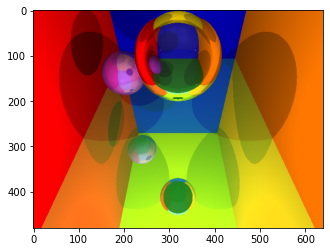

In [53]:
start_loading('bolha2.json')

Aqui é um espaço livre para o monitor responsável escolher algum arquivo json e fazer a leitura. sinta-se livre para adicionar algum arquivo de teste na pasta "terceira_versao/objetos" e lembre-se de colocar **apenas** o nome do arquivo, sem a extensão .json no próximo passo

In [ ]:
file = input("Digite o nome do arquivo sem o .json no final")
start_loading(f"{file}.json")